<a href="https://colab.research.google.com/github/scott-huberty/DeepUnderstandingOfDeepLearning/blob/codechallenges/metaparams/DUDL_data_CodeChallengeUbalanced_Scott.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Compare relu variants
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [2]:
def get_dataset(quality_threshold):
  # First read the data
  url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
  df = pd.read_csv(url, sep=';')

  # Outliers
  df = df[df['total sulfur dioxide'] < 200]

  # Z-score
  predictors = df.columns.drop(["quality"])
  df[predictors] = df[predictors].apply(stats.zscore)

  # Binarize the quality
  df['boolQuality'] = 0
  df.loc[df["quality"] > quality_threshold, "boolQuality"] = 1
  return df


def create_dataloaders(quality_threshold):
  df = get_dataset(quality_threshold)

  X = df.drop(['quality','boolQuality'], axis=1)
  y = df["boolQuality"].values

  predictors = torch.tensor(X.values, dtype=torch.float)
  labels = torch.tensor(y, dtype=torch.float)
  labels = labels[: ,None] # transform to matrix

  train_data, test_data, train_labels, test_labels = train_test_split(predictors, labels, test_size=0.1)

  train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
  test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

  batch_size = 64
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0] )

  return train_loader, test_loader

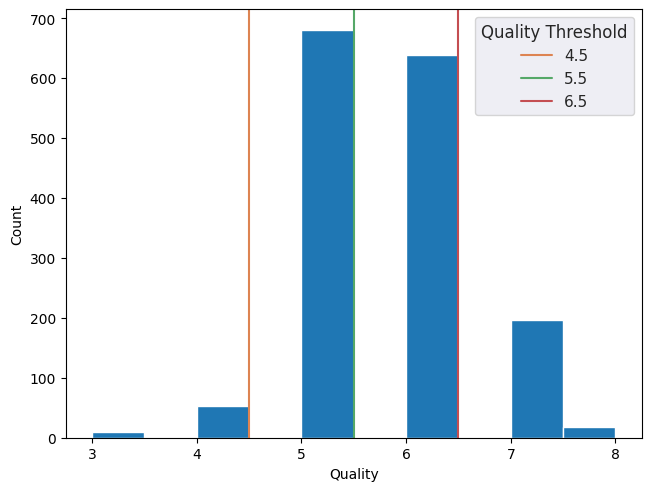

63 bad wines and 1534 good wines
Percent Bad rated wines: 0.04
744 bad wines and 853 good wines
Percent Bad rated wines: 0.47
1382 bad wines and 215 good wines
Percent Bad rated wines: 0.87


In [3]:
data1 = get_dataset(quality_threshold=4.5)
data2 = get_dataset(quality_threshold=5.5)
data3 = get_dataset(quality_threshold=6.5)

fig, ax = plt.subplots(constrained_layout=True)
sns.set(style="darkgrid")
colors = sns.color_palette()

ax.hist(data1["quality"])
ax.axvline(4.5, color=colors[1], label="4.5")
ax.axvline(5.5, color=colors[2], label="5.5")
ax.axvline(6.5, color=colors[3], label="6.5")
ax.legend(title="Quality Threshold")
ax.set_xlabel("Quality")
ax.set_ylabel("Count")
plt.show()

for data in [data1, data2, data3]:
  bad = data.loc[data["boolQuality"] == 0]
  good = data.loc[data["boolQuality"] == 1]
  print(f"{len(bad)} bad wines and {len(good)} good wines")
  perc = len(bad) / (len(bad) + len(good))
  # format to 2 decimals
  print(f"Percent Bad rated wines: {perc:.2f}")

# Now for the DL part

In [4]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11, 16)

    ### hidden layers
    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    ### output layer
    self.output = nn.Linear(32, 1)

    self.leakyrelu = nn.LeakyReLU()

  # forward pass
  def forward(self, x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    x = self.leakyrelu(self.input(x))
    x = self.leakyrelu(self.fc1(x))
    x = self.leakyrelu(self.fc2(x))
    return self.output(x)

# Train the model

In [17]:
NUM_EPOCHS = 500

def compute_accuracy(predictions, labels):
  """Compute accuracy for binary classification."""
  return 100 * torch.mean(((predictions > 0) == labels).float()).item()

def train_the_model(quality_threshold, num_epochs=500):
  """Train the Winet Model."""
  train_loader, test_loader = create_dataloaders(quality_threshold=quality_threshold)
  winenet = ANNwine()

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(), lr=.001)

  # initialize losses
  losses   = torch.zeros(num_epochs)
  trainAcc = []
  test_accs = xr.DataArray(
      np.zeros([num_epochs, 3]),
      dims=("epoch", "quality"),
      coords={"epoch": np.arange(num_epochs),
              "quality": ["all", "good", "bad"],
              },
  )
  # loop over epochs
  for epochi in range(num_epochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for predictors, labels in train_loader:

      # forward pass and loss
      predictions = winenet(predictors)
      loss = lossfun(predictions, labels)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      accuracy = compute_accuracy(predictions, labels)
      batchAcc.append(accuracy)
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X, y = next(iter(test_loader)) # extract X, y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    acc_all = compute_accuracy(yHat, y)
    acc_bad = compute_accuracy(yHat[y.squeeze() == 0], y[y.squeeze() == 0])
    acc_good = compute_accuracy(yHat[y.squeeze() == 1], y[y.squeeze() == 1])
    test_accs.loc[{"epoch": epochi, "quality": "all"}] = acc_all
    test_accs.loc[{"epoch": epochi, "quality": "good"}] = acc_good
    test_accs.loc[{"epoch": epochi, "quality": "bad"}] = acc_bad
  return trainAcc, test_accs, losses

In [23]:
import xarray as xr

thresholds = [4.5, 5.5, 6.5]

train_results = np.zeros((NUM_EPOCHS, len(thresholds)))
train_results = xr.DataArray(
    train_results,
    dims=("epoch", "threshold"),
    coords={"epoch": np.arange(NUM_EPOCHS), "threshold": thresholds},
    )

test_results  = np.zeros((NUM_EPOCHS, 3, len(thresholds)))
test_results = xr.DataArray(
    test_results,
    dims=("epoch", "quality", "threshold"),
    coords={"epoch": np.arange(NUM_EPOCHS),
            "quality": ["all", "good", "bad"],
            "threshold": thresholds},
    )

losses = np.zeros((NUM_EPOCHS, len(thresholds)))
losses = xr.DataArray(
    losses,
    dims=("epoch", "threshold"),
    coords={"epoch": np.arange(NUM_EPOCHS), "threshold": thresholds},
    )

ds = xr.Dataset(
    {
        "train_results": train_results,
        "test_results": test_results,
        "losses": losses,
    }
)

for ti, this_threshold in enumerate(thresholds):
  # create a model and train it
  (train_results.loc[{"threshold": this_threshold}],
   test_results.loc[{"threshold": this_threshold}],
   losses.loc[{"threshold": this_threshold}]
   ) = train_the_model(this_threshold)

In [28]:
losses

<xarray.DataArray (epoch: 500, threshold: 3)> Size: 12kB
array([[5.36467195e-01, 6.85061991e-01, 6.76503778e-01],
       [3.93106639e-01, 6.49312317e-01, 5.73862493e-01],
       [2.38505170e-01, 5.92406750e-01, 4.13897902e-01],
       ...,
       [1.27139487e-04, 1.04250923e-01, 3.23740020e-03],
       [1.06366599e-04, 1.01201870e-01, 3.38645466e-03],
       [9.47923181e-05, 9.84813198e-02, 2.86160526e-03]])
Coordinates:
  * epoch      (epoch) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * threshold  (threshold) float64 24B 4.5 5.5 6.5

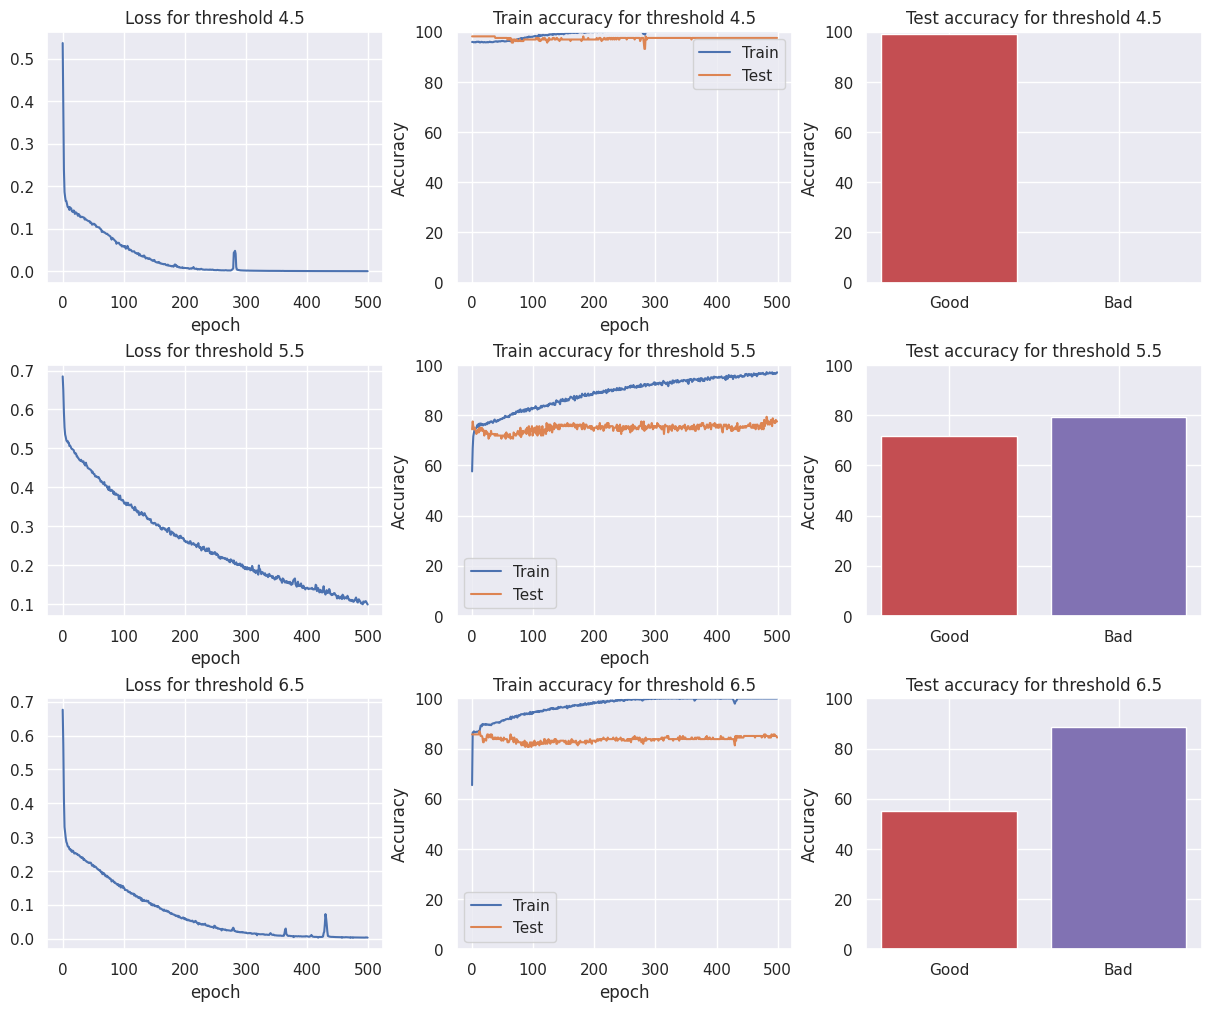

In [44]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10), constrained_layout=True)
colors = sns.color_palette()

for thresh, ax in zip(thresholds, axes[:, 0]):
  losses.sel(threshold=thresh).plot(ax=ax)
  ax.set_title(f'Loss for threshold {thresh}')

for thresh, ax in zip(thresholds, axes[:, 1]):
  train_results.sel(threshold=thresh).plot(ax=ax, label="Train")
  test_results.sel(threshold=thresh, quality="all").plot(ax=ax, label="Test")
  ax.legend()
  ax.set_title(f'Train accuracy for threshold {thresh}')
  ax.set_ylim([0, 100])
  ax.set_ylabel("Accuracy")

# Accuracy computed per quality bin
for thresh, ax in zip(thresholds, axes[:, 2]):
  good_acc = test_results.sel(threshold=thresh, quality="good").mean("epoch")
  bad_acc = test_results.sel(threshold=thresh, quality="bad").mean("epoch")
  ax.bar(["Good", "Bad"], [good_acc, bad_acc], color=[colors[3], colors[4]])
  ax.set_title(f'Test accuracy for threshold {thresh}')
  ax.set_ylim([0, 100])
  ax.set_ylabel("Accuracy")


# Additional explorations

In [ ]:
# This was a pretty straightforward codeChallenge, so there isn't much to expand. Feel free to try exploring the
# standard DL metaparameters, including learning rate, number of training epochs, and batch size.
#
# It's also interesting the include other activation functions into the comparison. The following site lists the functions.
#   https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
